<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/New_Attack_v23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
import scipy.stats as st

from tqdm import tqdm
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import tensorflow
import numpy
import matplotlib.pyplot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [ ]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [ ]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Pre-procesing

## Get working df

In [ ]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)
  
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

### Cutoff main

In [ ]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df
  
def main_cutoff(input_path):
  print('Reading data from file.')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  df.iloc[0].fillna(method='bfill', inplace=True)
  df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  cut_point = cut_off_idx(df)
  working_df = select_working_data(df, cut_point)

  return working_df

In [ ]:
#input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"
#orking_df = main_cutoff(input_path)
#display(working_df)

#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

## Get data

In [ ]:
input_path = path + "/Spectrum/NN/new_data_working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [ ]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

In [ ]:
def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 3000):
  X=None
  Y=np.array([])
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]
  samples_df = pd.merge(dist_df, freq_df, left_index=True, right_index=True)
  samples_df = samples_df.sort_values(by='Distance_km')
  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 0].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 1:samples_df.shape[1]]
  
  return X, Y, samples_df

In [ ]:
#input_data_path=path+"/rawData"
#distances=[i for i in range(1,26)]
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 'all', span_length=80,  min_dist = 0, max_dist = 3000)

In [ ]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-30.766774,-35.433400,-39.636295,-39.572805,...,-36.158246,-34.974566,-33.677152,-32.461789,-31.697031,-30.033924,-33.492361,-34.387412,-33.308819,-30.242322
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.063281,-32.262853,-35.781499,-35.580851,...,-32.811077,-33.647974,-34.523244,-34.873656,-38.167460,-35.568105,-38.499464,-41.863667,-44.503764,-46.884585
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-32.485086,-34.725450,-31.833082,-35.461288,...,-39.867905,-42.487405,-36.881447,-32.796440,-31.492113,-36.181981,-36.404388,-32.599868,-32.605291,-35.086710
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.223232,-30.862095,-28.720843,-31.102346,...,-34.051539,-35.013313,-33.634516,-34.267799,-36.189625,-35.279263,-33.557900,-30.107759,-31.016528,-34.939487


# Vanila Attack

In [ ]:
def get_eval_data(source_df, target_df, num_eval_samples = 10):
  import random
  source_val_list = [i for i in range(1, len(source_df))]
  source_random_list = random.choices(source_val_list, k = num_eval_samples)

  target_val_list = [i for i in range(1, len(target_df))]
  target_random_list = random.choices(target_val_list, k = num_eval_samples)

  eval_source_df = source_df.iloc[source_random_list]
  eval_target_df = target_df.iloc[target_random_list]

  return eval_source_df, eval_target_df

In [ ]:
def get_filtered_data(df, alpha = 0.90):
  data_df = df.iloc[:, 1:df.shape[1]]
  ci_arr = []
  filtered_data = []
  mean_data = []
  for i in range(0, data_df.shape[1]):
    eval_col = data_df.iloc[:,i].to_numpy()
    ci = st.t.interval(alpha=alpha, df=len(eval_col)-1, loc=np.mean(eval_col), scale=st.sem(eval_col))
    ci = (round(ci[0], 5), round(ci[1], 5))
    ci_arr.append(ci)
    filter_data = eval_col[(eval_col > ci[0]) & (eval_col < ci[1])]
    filter_data = np.round_(filter_data, decimals = 5)
    filtered_data.append(filter_data)
    mean_data.append(round(np.mean(filter_data), 5))
  return ci_arr, filtered_data, mean_data

In [ ]:
def get_delta(source_mean_data, target_mean_data):
  deltas = []
  for i in range(len(source_mean_data)):
    delta = round(source_mean_data[i]-target_mean_data[i], 5)
    deltas.append(delta)
    
  return deltas

In [ ]:
def mod_target(source_filtered_data, deltas_calc, delta_allowance= 0.05):
  import random
  cnt = 0
  mod_target_samples = []
  for col in source_filtered_data:
    mod_target_col = []
    for val in col:
      if deltas_calc[cnt]<(-delta_allowance):
        new_val = val + (deltas_calc[cnt]+random.uniform(-2, 2))
      elif deltas_calc[cnt]>(delta_allowance):
        new_val = val - (deltas_calc[cnt]+random.uniform(-2, 2))
      else:
        new_val = val+(deltas_calc[cnt]+random.uniform(-2, 2))
      new_val = round(new_val, 5)
      mod_target_col.append(new_val)
    cnt += 1
    mod_target_samples.append(mod_target_col)
  return mod_target_samples

In [ ]:
def get_mod_target_sample(mod_source_samples):
  from scipy.signal import savgol_filter

  mod_result = []
  for col in mod_source_samples:
    mod_result.append(round(np.mean(col), 5))

  mod_result_smoothed = savgol_filter(mod_result, 7, 4)
  return mod_result_smoothed

In [ ]:
def main_mod_data(source_df, target_df, num_eval_samples = 30, alpha=0.95, delta_allowance=0.005):
  eval_source_df, eval_target_df = get_eval_data(source_df, target_df, num_eval_samples = num_eval_samples)
  source_ci_arr, source_filtered_data, source_mean_data = get_filtered_data(eval_source_df, alpha = 0.99)
  target_ci_arr, target_filtered_data, target_mean_data = get_filtered_data(eval_target_df, alpha = alpha)
  deltas_calc = get_delta(source_mean_data, target_mean_data)
  mod_source_samples = mod_target(source_filtered_data, deltas_calc, delta_allowance = delta_allowance)
  mod_result_smoothed = get_mod_target_sample(mod_source_samples)

  return mod_result_smoothed, source_mean_data, target_mean_data

In [ ]:
num_of_new_moded_samples = 5
source_val = 2000
target_val = 80
source_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == source_val]
target_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == target_val]

col_headers = samples_filtered_df.columns.values.tolist()
col_headers = col_headers[1:]

data = []
for i in tqdm(range(0, num_of_new_moded_samples)):
  mod_result_smoothed, source_mean_data, target_mean_data = main_mod_data(source_df, target_df, num_eval_samples = 30, alpha=0.95, delta_allowance=0.05)
  data.append(mod_result_smoothed)

moded_samples_df = pd.DataFrame(data, columns = col_headers)

moded_samples_df.to_csv(path+"/Spectrum/attack_vanila/moded_data_"+str(source_val)+"_to_"+str(target_val)+".csv", index=False)

100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


# Test Vanila Attack

In [ ]:
testing_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == 80]
mod_data_df = testing_df.iloc[:, 1:testing_df.shape[1]]

In [ ]:
#vanila
#mod_data_df = pd.read_csv(path+"/Spectrum/attack_vanila/moded_data_2000_to_80.csv")
#vae
#mod_data_df = pd.read_csv(path+"/Spectrum/attack_vae/syntectic_data/moded_data_80.csv")

reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_10_reference_30.csv")
sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_10_reference_30.csv")

In [ ]:
mod_data_df

,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,-39.625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,-57.196731,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,-56.009250,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,-60.589516,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,-58.101871,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,-62.890823,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,-58.154296,-64.388711,-67.189286,-64.966716,-63.945167,-54.811000,-55.034298,-57.661727,-58.296363,-58.392978,...,-60.129552,-60.195580,-57.788352,-56.225607,-60.441628,-64.069162,-58.504497,-50.773918,-53.255245,-63.911235
1725,-61.059269,-51.097763,-51.385651,-64.695003,-72.047386,-67.752279,-53.344034,-58.746983,-62.551051,-59.265874,...,-65.563257,-68.322825,-64.959770,-63.562047,-67.362623,-64.823481,-55.356511,-53.788102,-53.048652,-54.800086
2400,-57.404439,-57.568700,-57.373373,-54.970622,-56.970633,-56.927833,-55.382226,-56.413546,-60.405413,-59.878069,...,-59.508979,-63.718585,-62.419798,-61.790442,-62.008392,-66.239532,-60.310753,-62.230813,-61.497986,-60.658025
1675,-70.696618,-65.303756,-60.683876,-57.875370,-54.574001,-53.748213,-58.920613,-65.129243,-69.102172,-62.891362,...,-55.859031,-57.273496,-54.406578,-61.030509,-61.955984,-62.319736,-55.400181,-55.312056,-59.259579,-66.898471


In [ ]:
freq_in_references = reference_freq_data_df.columns.values.tolist()
headers_in_references = freq_in_references[6:]

mod_data_df_freq_filtered = mod_data_df[headers_in_references]
mod_data = mod_data_df_freq_filtered.to_numpy()

In [ ]:
def get_features(data, data_Y, reference_freq_data_df):

  features_data = []

  for data_X in data:
    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,6:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    features_data.append([round(np.std(data_X), 5), #mean
                          round(np.mean(data_X), 5), #std 
                          round(np.min(pearson_vals), 5), #pearson min
                          round(np.mean(pearson_vals), 5), #pearson mean
                          round(np.max(pearson_vals), 5), #pearson max
                          round(np.min(confidence_vals_lower), 5), #delta ci min
                          round(np.min(confidence_vals_upper), 5)]) #delta ci max

  return features_data

In [ ]:
features_data = get_features(mod_data, 80, reference_freq_data_df)

scaler = MinMaxScaler()
features_data_scaled = scaler.fit(features_data)
features_data = features_data_scaled.transform(features_data)

In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 7, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(9,activation='tanh'))
    model.add(Dense(9,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model

# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=2500, batch_size=8, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/NNs/mod_bootstraped_final_new_data_NN_model_freq_10_reference_30_epochs_2500.h5")

# Predit
Y_test_pred=mm.predict(features_data)
pred=list(Y_test_pred)

dist_min=80
dist_max=2000

pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

In [ ]:
pred_abs

array([ 237.78748 ,  146.389   ,  686.5667  ,  451.6942  ,  465.19058 ,
        649.9313  ,  236.1405  , 1161.6904  , 1121.5084  , 1531.7812  ,
        -87.430435, 1301.5176  ,  936.1394  , 1233.4695  ,  396.23126 ,
        422.396   ,  192.86095 , 1448.655   ,  260.60706 ,  331.55292 ,
        493.79993 ,  236.8335  ,  175.23698 , -126.47133 ,  542.4116  ,
         73.23311 ,  512.3385  ,  390.32425 , 1690.3721  ,  715.96216 ,
         92.994194,  228.87727 ,   75.526505, 1530.1511  ,  250.63438 ,
        644.79926 , 1541.3842  ,  554.8082  ,  471.59702 ,  288.41827 ,
        505.3758  ,  524.6513  ,  606.137   ,  596.21783 ,  647.15094 ,
       1970.3639  ,  471.26703 ,  450.9181  ,  976.8418  ,  512.3561  ,
        255.72295 ,  698.71735 , 1114.752   , 1747.2689  ,  107.043076,
        167.275   ,  649.2396  ,  249.13681 ,  518.25885 ,  373.96878 ,
       1911.2941  ,  559.39136 ,  518.52136 ,  224.83105 ,  500.63983 ,
        235.63896 ,  338.49222 ,  551.7742  , 1586.2864  ,  615.

# Variational AutoEncoder Attack

In [ ]:
import tensorflow
import numpy
import matplotlib.pyplot

In [ ]:
input_size = samples_filtered_df.shape[1] - 1
latent_space_dim = 2
distance_to_eval = 80

## load dataset

In [ ]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,80,-58.154296,-64.388711,-67.189286,-64.966716,-63.945167,-54.811000,-55.034298,-57.661727,-58.296363,...,-60.129552,-60.195580,-57.788352,-56.225607,-60.441628,-64.069162,-58.504497,-50.773918,-53.255245,-63.911235
1725,80,-61.059269,-51.097763,-51.385651,-64.695003,-72.047386,-67.752279,-53.344034,-58.746983,-62.551051,...,-65.563257,-68.322825,-64.959770,-63.562047,-67.362623,-64.823481,-55.356511,-53.788102,-53.048652,-54.800086
2400,80,-57.404439,-57.568700,-57.373373,-54.970622,-56.970633,-56.927833,-55.382226,-56.413546,-60.405413,...,-59.508979,-63.718585,-62.419798,-61.790442,-62.008392,-66.239532,-60.310753,-62.230813,-61.497986,-60.658025
1675,80,-70.696618,-65.303756,-60.683876,-57.875370,-54.574001,-53.748213,-58.920613,-65.129243,-69.102172,...,-55.859031,-57.273496,-54.406578,-61.030509,-61.955984,-62.319736,-55.400181,-55.312056,-59.259579,-66.898471


In [ ]:
samples_filtered_df = samples_filtered_df.query('Distance_km == '+str(distance_to_eval))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(samples_filtered_df.values[:, 1:samples_filtered_df.values.shape[1]], samples_filtered_df.values[:, 0], test_size=0.2, random_state=111)

scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)

max_scaled = scaler.data_max_
min_scaled = scaler.data_min_

x_train = data_scaled.transform(x_train)
x_test = data_scaled.transform(x_test)

model_path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/trainedModel"
joblib.dump(scaler, model_path+'/scaler_vae.joblib')

## encoder

In [ ]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(input_size,), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=512, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="encoder_relu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=256, name="encoder_dense_2")(encoder_activ_layer1)
encoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_2")(encoder_dense_layer2)

encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=128, name="encoder_dense_3")(encoder_activ_layer2)
encoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_3")(encoder_dense_layer3)

encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_4")(encoder_activ_layer3)
encoder_activ_layer4 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_4")(encoder_dense_layer4)

encoder_dense_layer5 = tensorflow.keras.layers.Dense(units=32, name="encoder_dense_5")(encoder_activ_layer4)
encoder_activ_layer5 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_5")(encoder_dense_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

## decoder

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_input_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_input_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_input_layer1)

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_1")(decoder_reshape)
decoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="decoder_relu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=128, name="decoder_dense_2")(decoder_activ_layer1)
decoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="decoder_relu_2")(decoder_dense_layer2)

decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=256, name="decoder_dense_3")(decoder_activ_layer2)
decoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="decoder_relu_3")(decoder_dense_layer3)

decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=512, name="decoder_dense_4")(decoder_activ_layer3)
decoder_activ_layer4 = tensorflow.keras.layers.ReLU(name="decoder_relu_4")(decoder_dense_layer4)

decoder_dense_layer5 = tensorflow.keras.layers.Dense(units=input_size, name="decoder_dense_5")(decoder_activ_layer4)
decoder_output = tensorflow.keras.layers.ReLU(name="decoder_output")(decoder_dense_layer5)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

## vae

In [ ]:
vae_input = tensorflow.keras.layers.Input(shape=(input_size), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 2397)]            0         
                                                                 
 encoder_model (Functional)  (None, 2)                 1402468   
                                                                 
 decoder_model (Functional)  (None, 2397)              1404797   
                                                                 
Total params: 2,807,265
Trainable params: 2,807,265
Non-trainable params: 0
_________________________________________________________________


## loss and compile

In [ ]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = len(x_test)  
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

## train

Training with 15 epochs ...


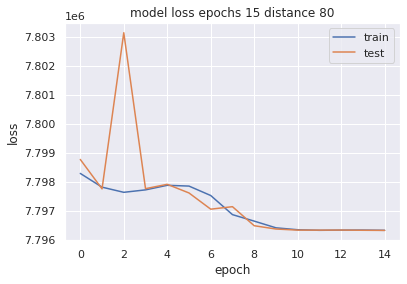

------------------------------------------------------
Training with 50 epochs ...


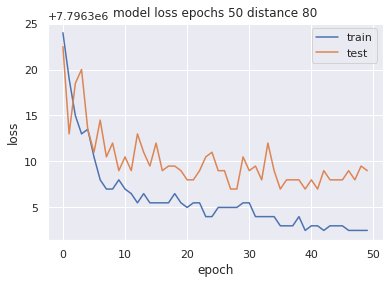

------------------------------------------------------
Training with 100 epochs ...


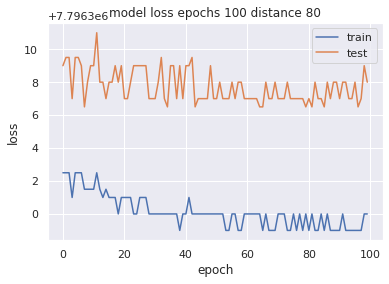

------------------------------------------------------
Training with 500 epochs ...


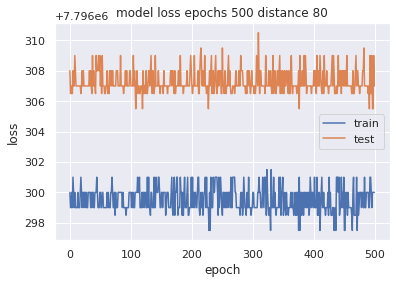

------------------------------------------------------
Training with 1000 epochs ...


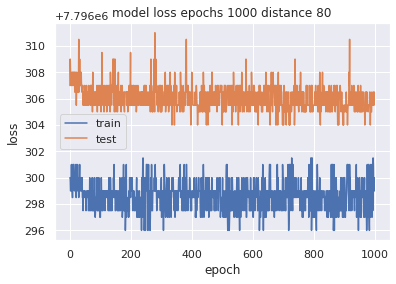

------------------------------------------------------


In [ ]:
epochs_test = [15, 50, 100, 500, 1000]
for et in epochs_test:
  print('Training with {} epochs ...'.format(et))
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
  history = vae.fit(x_train, y_train, epochs=et, batch_size=32, shuffle=True, validation_data=(x_test, y_test), verbose=0) # , callbacks=[early_stopping], 

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss epochs {} distance {}'.format(et, distance_to_eval))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig(path+"/Spectrum/attack_vae/loss_plots/VAE_loss_epochs_"+str(et)+"_distance_"+str(distance_to_eval)+".png")
  plt.show()

  # save autoencoder
  encoder.save(path+"/Spectrum/attack_vae/autoencoder/VAE_encoder_epochs_"+str(et)+"_distance_"+str(distance_to_eval)+".h5") 
  decoder.save(path+"/Spectrum/attack_vae/autoencoder/VAE_decoder_epochs_"+str(et)+"_distance_"+str(distance_to_eval)+".h5") 
  vae.save(path+"/Spectrum/attack_vae/autoencoder/VAE_epochs_"+str(et)+"_distance_"+str(distance_to_eval)+".h5")

  print('------------------------------------------------------')

## test model

In [ ]:
epochs_num = 100

encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_encoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)
decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_decoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

----------Decoded_Original------------
[1.376119  0.        0.        ... 1.3728728 0.        0.       ]
----------Decoded_Mod/10------------
[0.73102367 0.59341176 0.59341176 ... 0.73069905 0.59341176 0.59341176]
----------Inverted Decoded_Mod------------
[-54.77533146 -58.33876174 -58.1637022  ... -55.88650063 -58.65650506
 -60.17014862]
----------X_test------------
[0.1689451  0.2781684  0.48009138 ... 0.95236009 0.96324752 0.65855078]
----------Inverted X_test------------
[-69.47083024 -63.95298397 -60.23500229 ... -51.67834439 -53.09245393
 -58.49390386]


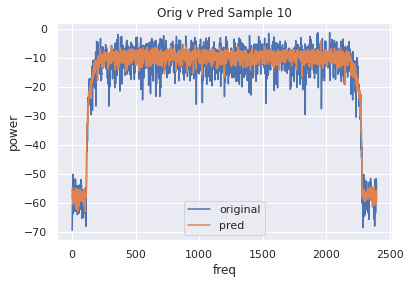

------------------------------------------------------


In [ ]:
inverted_decoded_data = scaler.inverse_transform(decoded_data)
inverted_x_test = scaler.inverse_transform(x_test)
decoded_result = []

# Adjusting data convertion and range
cnt = 0
for sample in decoded_data:
  sample_decoded = []
  delta_samples = []
  delta_cnt = 0
  for v in sample:
    sample_decoded.append((v/10))
    if delta_cnt <=50:
      delta_samples.append(round(((v/10) - x_test[cnt][delta_cnt]), 3))
    delta_cnt += 1
  delta_test_decoded = np.mean(delta_samples)
  if delta_test_decoded < 0:    
    new_sample_decoded = [x+abs(delta_test_decoded) for x in sample_decoded]
  elif delta_test_decoded > 0:
    new_sample_decoded = [x-abs(delta_test_decoded) for x in sample_decoded]
  else:
    new_sample_decoded = sample_decoded
  decoded_result.append(new_sample_decoded)
  cnt += 1

decoded_result = np.array(decoded_result)
inverted_decoded_results = scaler.inverse_transform(decoded_result)
check_plots_samples = [10]
for cps in check_plots_samples:
  print('----------Decoded_Original------------')
  print(decoded_data[cps])
  print('----------Decoded_Mod/10------------')
  print(decoded_result[cps])
  print('----------Inverted Decoded_Mod------------')
  print(inverted_decoded_results[cps])
  print('----------X_test------------')
  print(x_test[cps])
  print('----------Inverted X_test------------')
  print(inverted_x_test[cps])
  plt.plot(inverted_x_test[cps], label='original')  
  plt.plot(inverted_decoded_results[cps], label='pred')

  plt.title('Orig v Pred Sample {}'.format(cps))
  plt.ylabel('power')
  plt.xlabel('freq')
  plt.legend(loc='best')
  plt.show()
  print('------------------------------------------------------')

## Create final modification for synthetic data

In [ ]:
from scipy.signal import savgol_filter

# Combined test samples by mean of 0.9 CI data points er columns
combined_sample_x_test = []
for i in range(len(inverted_x_test[0])):
  col_val = []
  for sample in inverted_x_test:
    col_val.append(sample[i])
  ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
  col_val = np.array(col_val)
  col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]
  
  combined_sample_x_test.append(np.mean(col_val))

# Combined decoded samples by mean of 0.9 CI data points er columns
combined_sample_decoded_results = []
for i in range(len(inverted_decoded_results[0])):
  col_val = []
  for sample_col in inverted_decoded_results:
    col_val.append(sample_col[i])
  ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
  col_val = np.array(col_val)
  col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]    
  combined_sample_decoded_results.append(np.mean(col_val))

combined_sample_decoded_results = savgol_filter(combined_sample_decoded_results, 7, 3)

In [ ]:
print(combined_sample_decoded_results)

[-56.76101641 -59.22427959 -59.98573224 ... -57.91286958 -59.36579981
 -61.94829834]


[-59.764787128488, -59.926651610002246, -60.69784528812719, -60.539361819263036, -58.89255621791224, -57.96189579926683, -57.774972279788216, -59.668212142923366, -59.71106135808736, -59.46722298533744, -60.91408526312942, -60.55618035720494, -58.995463982075684, -58.916175350694246, -60.43561102403802, -59.08863538348017, -58.19729117872706, -57.921039323261546, -58.53827919456596, -59.46668809148053, -57.78689572398485, -57.92550278463549, -57.83749884925871, -59.173716865038855, -60.75644655913222, -60.83404694871823, -59.52032118951413, -60.46582988178384, -61.57063253034806, -58.17204800821927, -58.15405551591926, -59.35427437479895, -60.1412272935191, -59.6088445062083, -58.92813820434687, -60.21633672094457, -59.20590879625975, -60.001931367039084, -58.777706468474356, -57.893613198471364, -58.76577955833063, -59.822887709716895, -59.57360911223866, -58.558903109627224, -57.89366373121028, -59.188637120740424, -59.03713181827548, -59.2730931861961, -60.59320156960098, -59.939532

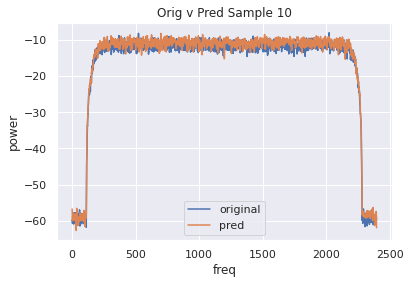

In [ ]:
print(combined_sample_x_test)
print(combined_sample_decoded_results)
plt.plot(combined_sample_x_test, label='original')
plt.plot(combined_sample_decoded_results, label='pred')

plt.title('Orig v Pred Sample {}'.format(cps))
plt.ylabel('power')
plt.xlabel('freq')
plt.legend(loc='best')
plt.show()

## Generate sample data

In [ ]:
def get_vae_moded_data(samples_filtered_df, encoder, decoder, num_sample_to_generate = 30, epochs_num = 100, distance_to_eval = 80, sensitivity=2):
  import random
  from scipy.signal import savgol_filter

  encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_encoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)
  decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_decoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)

  samples_filtered_df = samples_filtered_df.query('Distance_km == '+str(distance_to_eval))
  samples_genrated = []

  col_headers = samples_filtered_df.columns.values.tolist()
  col_headers = col_headers[1:]

  for generate_sample_cnt in tqdm(range(0, num_sample_to_generate)):
    # Load dataset
    x_train, x_test, y_train, y_test = train_test_split(samples_filtered_df.values[:, 1:samples_filtered_df.values.shape[1]], samples_filtered_df.values[:, 0], test_size=0.2, random_state=111)

    scaler = MinMaxScaler()
    data_scaled = scaler.fit(x_train)

    max_scaled = scaler.data_max_
    min_scaled = scaler.data_min_

    x_train = data_scaled.transform(x_train)
    x_test = data_scaled.transform(x_test)

    # predit
    encoded_data = encoder.predict(x_test)
    decoded_data = decoder.predict(encoded_data)

    decoded_result = []
    # Adjusting data convertion and range
    cnt = 0
    for sample in decoded_data:
      sample_decoded = []
      delta_samples = []
      delta_cnt = 0
      for v in sample:
        sample_decoded.append((v/10))
        if delta_cnt <=50:
          delta_samples.append(round(((v/10) - x_test[cnt][delta_cnt]), 3))
        delta_cnt += 1
      delta_test_decoded = np.mean(delta_samples)
      if delta_test_decoded < 0:    
        new_sample_decoded = [x+abs(delta_test_decoded) for x in sample_decoded]
      elif delta_test_decoded > 0:
        new_sample_decoded = [x-abs(delta_test_decoded) for x in sample_decoded]
      else:
        new_sample_decoded = sample_decoded
      decoded_result.append(new_sample_decoded)
      cnt += 1

    decoded_result = np.array(decoded_result)
    inverted_decoded_results = scaler.inverse_transform(decoded_result)

    # Combined decoded samples by mean of 0.9 CI data points er columns
    combined_sample_decoded_results = []
    for i in range(len(inverted_decoded_results[0])):
      col_val = []
      for sample_col in inverted_decoded_results:
        col_val.append(sample_col[i])
      ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
      col_val = np.array(col_val)
      col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]  
      mean_col = np.mean(col_val)
      std_col = np.std(col_val)
      final_col_val = mean_col + (std_col*random.uniform(-sensitivity, sensitivity)) # adding randomess to calc
        
      combined_sample_decoded_results.append(final_col_val)

    combined_sample_decoded_results = savgol_filter(combined_sample_decoded_results, 7, 3)

    samples_genrated.append(combined_sample_decoded_results)

  vae_samples_df = pd.DataFrame(samples_genrated, columns = col_headers)

  vae_samples_df.to_csv(path+"/Spectrum/attack_vae/syntectic_data/moded_data_"+str(distance_to_eval)+".csv", index=False)

  return vae_samples_df

In [ ]:
vae_samples_df = get_vae_moded_data(samples_filtered_df, encoder, decoder, num_sample_to_generate = 30, epochs_num = 100, distance_to_eval = 80, sensitivity=8)

100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


# Abnormaly detector

In [ ]:
# load regular data
distance_to_eval = 80

input_path = path + "/Spectrum/NN/new_data_working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

distances = [x*80 for x in range(1, 26)]
X, Y, real_data_df = get_data(working_df, distances, num_features = 'all', span_length=80,  min_dist = 0, max_dist = 3000)

real_data_df = real_data_df.query('Distance_km == '+str(distance_to_eval))
real_data_df.drop('Distance_km', axis=1, inplace=True)
type_of_data_col_vals = [int(0) for i in range(0, real_data_df.shape[0])]
real_data_df.insert(0, "type_of_data", type_of_data_col_vals, True)

In [ ]:
# load mod data
data_to_test  ='vae'
#vanila
if data_to_test == 'vanilla':
  mod_data_df = pd.read_csv(path+"/Spectrum/attack_vanila/moded_data_2000_to_80.csv")
#vae
else:
  mod_data_df = pd.read_csv(path+"/Spectrum/attack_vae/syntectic_data/moded_data_80.csv")
  #distance_col_vals = [int(distance_to_eval) for i in range(0, mod_data_df.shape[0])]
  #mod_data_df.insert(0, "Distance_km", distance_col_vals, True)
type_of_data_col_vals = [int(1) for i in range(0, mod_data_df.shape[0])]
mod_data_df.insert(0, "type_of_data", type_of_data_col_vals, True)

In [ ]:
#join real and mod data
combined_df = pd.concat([real_data_df, mod_data_df], ignore_index=True)

In [ ]:
# get train test splits
x_train, x_test, y_train, y_test = train_test_split(combined_df.values, combined_df.values[:, 0], test_size=0.2, random_state=111)

scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)

x_train = data_scaled.transform(x_train)
x_test = data_scaled.transform(x_test)

In [ ]:
# separate into normal and anormal data
normal_train_data = pd.DataFrame(x_train).add_prefix('c').query('c0 == 0').values[:, 1:]
anormal_train_data = pd.DataFrame(x_train).add_prefix('c').query('c0 > 0').values[:, 1:]

normal_test_data = pd.DataFrame(x_test).add_prefix('c').query('c0 == 0').values[:, 1:]
anormal_test_data = pd.DataFrame(x_test).add_prefix('c').query('c0 > 0').values[:, 1:]

## model

In [ ]:
from tensorflow.keras.models import Model
class AutoEncoder_m(Model):
  def __init__(self):
    super(AutoEncoder_m, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        tf.keras.layers.Dense(64, activation='relu'),
                                        tf.keras.layers.Dense(32, activation='relu'),
                                        tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(8, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(2397, activation='sigmoid')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder_m = AutoEncoder_m()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

autoencoder_m.compile(optimizer='adam', loss='mae')

In [ ]:
distance_to_eval=80
epochs_num = 50

#train model
history = autoencoder_m.fit(normal_train_data, normal_train_data, epochs=epochs_num, batch_size=8, validation_data=(x_train[:,1:],x_train[:,1:]), shuffle=True, callbacks=[early_stopping], verbose=1)

# save model weigths
autoencoder_m.save_weights(path+"/Spectrum/defense_autoencoder/autoencoder/A_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5")

Epoch 1/50
10/10 [==============================] - 3s 62ms/step - loss: 0.1873 - val_loss: 0.1506
Epoch 2/50
10/10 [==============================] - 0s 17ms/step - loss: 0.1670 - val_loss: 0.1344
Epoch 3/50
10/10 [==============================] - 0s 19ms/step - loss: 0.1620 - val_loss: 0.1346
Epoch 4/50
10/10 [==============================] - 0s 15ms/step - loss: 0.1613 - val_loss: 0.1337
Epoch 5/50
10/10 [==============================] - 0s 15ms/step - loss: 0.1606 - val_loss: 0.1332
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 0.1605 - val_loss: 0.1343
Epoch 7/50
10/10 [==============================] - 0s 14ms/step - loss: 0.1605 - val_loss: 0.1329
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.1603 - val_loss: 0.1329
Epoch 9/50
10/10 [==============================] - 0s 19ms/step - loss: 0.1602 - val_loss: 0.1329
Epoch 10/50
10/10 [==============================] - 0s 17ms/step - loss: 0.1601 - val_loss: 0.1329
Epoch 11/

## Calc reconstruction loss

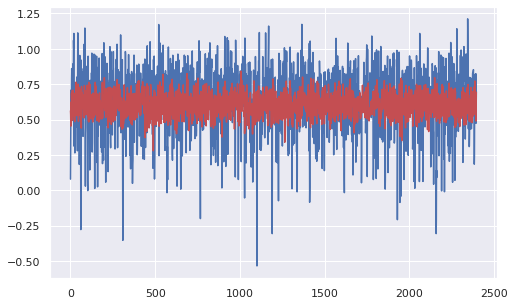

In [ ]:
# reconstruction loss low
encoder_out = autoencoder_m.encoder(normal_test_data).numpy()
decoder_out = autoencoder_m.decoder(encoder_out).numpy()

plt.figure(figsize=(8,5))
plt.plot(normal_test_data[0], 'b') # real data
plt.plot(decoder_out[0], 'r') # reconstructed data

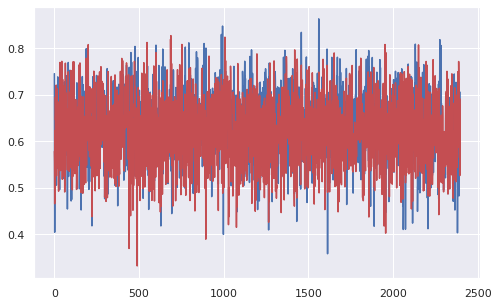

In [ ]:
#reconstruction loss high
encoder_out_a = autoencoder_m.encoder(anormal_test_data).numpy()
decoder_out_a = autoencoder_m.decoder(encoder_out_a).numpy()

plt.figure(figsize=(8,5))
plt.plot(anormal_test_data[0], 'b') # moded data
plt.plot(decoder_out_a[0], 'r') # reconstructed data

## Calculate threshold of normal data

(array([1., 0., 0., 0., 1., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.]),
 array([0.15972403, 0.15998484, 0.16024565, 0.16050646, 0.16076727,
        0.16102808, 0.16128889, 0.1615497 , 0.1618105 , 0.16207131,
        0.16233212, 0.16259293, 0.16285374, 0.16311455, 0.16337536,
        0.16363617, 0.16389698, 0.16415779, 0.1644186 , 0.16467941,
        0.16494022, 0.16520102, 0.16546183, 0.16572264, 0.16598345,
        0.16624426, 0.16650507, 0.16676588, 0.16702669, 0.1672875 ,
        0.16754831, 0.16780912, 0.16806993, 0.16833073, 0.16859154,
        0.16885235, 0.16911316, 0.16937397, 0.16963478, 0.16989559,
        0.1701564 , 0.17041721, 0.17067802, 0.17093883, 0.17119964,
        0.17146044, 0.17172125, 0.17198206, 0.17224287, 0.17250368,
        0.17276449]),
 <a list of 50 Patch objects>)

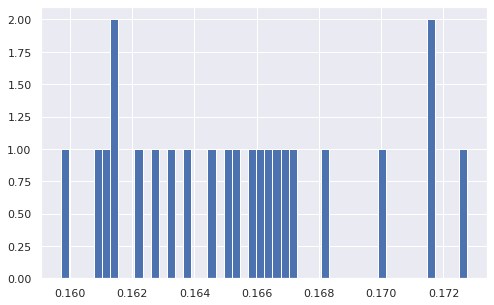

In [ ]:
# reconstrution error normal data
reconstructions = autoencoder_m.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data) # get loss between normal data and reconstructed data

plt.figure(figsize=(8,5))
plt.hist(train_loss, bins = 50) # plot loss between normal data and reconstructed data

In [ ]:
print(np.mean(train_loss)) # where most of the error is present (y axis)
print(np.std(train_loss)) # how sparse is the error (x axis)

# add to the mean 2 std spaces, any value below the threshold would be considered normal data, above anormal
sensitivity = 2

threshold_upper = np.mean(train_loss) + sensitivity*np.std(train_loss)
threshold_lower = np.mean(train_loss) - sensitivity*np.std(train_loss)
print(threshold_upper)
print(threshold_lower)

0.16545143813737798
0.0035665775182565818
0.17258459317389113
0.15831828310086482


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.0550765 , 0.05512036, 0.05516421, 0.05520807, 0.05525193,
        0.05529579, 0.05533965, 0.0553835 , 0.05542736, 0.05547122,
        0.05551508, 0.05555893, 0.05560279, 0.05564665, 0.05569051,
        0.05573437, 0.05577822, 0.05582208, 0.05586594, 0.0559098 ,
        0.05595365, 0.05599751, 0.05604137, 0.05608523, 0.05612909,
        0.05617294, 0.0562168 , 0.05626066, 0.05630452, 0.05634838,
        0.05639223, 0.05643609, 0.05647995, 0.05652381, 0.05656766,
        0.05661152, 0.05665538, 0.05669924, 0.0567431 , 0.05678695,
        0.05683081, 0.05687467, 0.05691853, 0.05696239, 0.05700624,
        0.0570501 , 0.05709396, 0.05713782, 0.05718167, 0.05722553,
        0.05726939]),
 <a list of 50 Patch objects>)

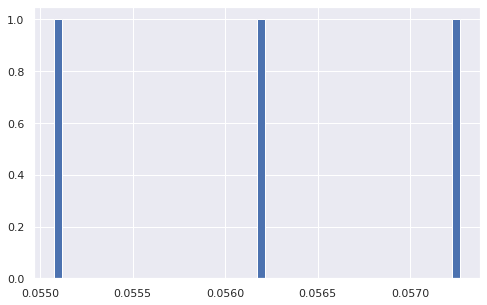

In [ ]:
# reconstrution error anormal data
reconstructions_a = autoencoder_m.predict(anormal_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anormal_test_data)

plt.figure(figsize=(8,5))
plt.hist(train_loss_a, bins = 50)

In [ ]:
print(np.mean(train_loss_a)) # where most of the error is present (y axis)
print(np.std(train_loss_a)) # how sparse is the error (x axis)

0.05617404901042728
0.0008952458024570053


## Classifying anormalites

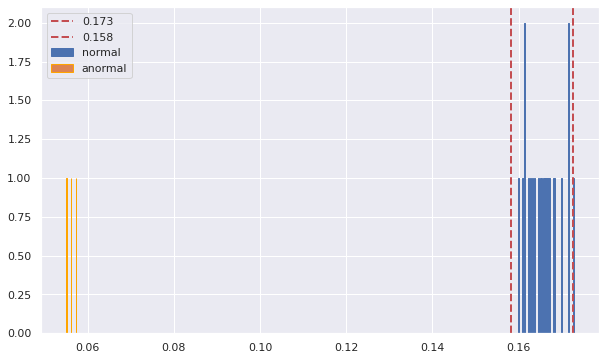

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(train_loss, bins=50, label='normal', edgecolor="b")
plt.hist(train_loss_a, bins=50, label='anormal', edgecolor="orange")
plt.axvline(threshold_upper, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold_upper))
plt.axvline(threshold_lower, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold_lower))
plt.legend(loc='best')
plt.show()

In [ ]:
# values in between thresholds for Normal data
preds_upper = tf.math.less(train_loss, threshold_upper) # return True to values less than threshold return false for values bigger
preds_lower = tf.math.greater(train_loss, threshold_lower)

preds = tf.logical_and(preds_upper, preds_lower)

num_of_norm_pred_wrong = tf.math.count_nonzero(preds) # number of normal values classify correctly
total_normal_data = preds.shape[0] # total amount of normal values

ratio_of_fp = num_of_norm_pred_wrong/total_normal_data
print(tensorflow.keras.backend.get_value(num_of_norm_pred_wrong))
print(total_normal_data)
print(round(tensorflow.keras.backend.get_value(ratio_of_fp), 5)) # ratio of normal values classify as normal

22
23
0.95652


In [ ]:
# values outside threshold Anormal data
preds_a_upper = tf.math.greater(train_loss_a, threshold_upper) # return True to values greater than threshold return false for values smaller
preds_a_lower = tf.math.less(train_loss_a, threshold_lower)

preds_a = tf.logical_or(preds_a_upper, preds_a_lower)

total_anormal_data = preds_a.shape[0] # total of anormal values
num_of_norm_pred_wrong_a = tf.math.count_nonzero(preds_a) # number of normal values classify correctly

ratio_of_fn = num_of_norm_pred_wrong_a/total_anormal_data
print(tensorflow.keras.backend.get_value(num_of_norm_pred_wrong_a))
print(total_anormal_data)
print(round(tensorflow.keras.backend.get_value(ratio_of_fn), 5)) # ratio of anormal values classify as anormal

3
3
1.0


## get index that are classify as anomalies

In [ ]:
preds_array = tensorflow.keras.backend.get_value(preds_a) 

values_classify_as_anormal_idx = []
values_classify_as_anormal = []
inverted_values_classify_as_anormal = []
idx_cnt = 0
for p_val in preds_array:
  if p_val == True:
    values_classify_as_anormal_idx.append(idx_cnt)
    a_sample =np.insert(anormal_test_data[idx_cnt], 0, 1.0)
    values_classify_as_anormal.append(a_sample)

In [ ]:
values_classify_as_anormal[0]

array([1.        , 0.7453449 , 0.54229407, ..., 0.59916186, 0.56363293,
       0.58156371])

In [ ]:
inverted_values_classify_as_anormal = scaler.inverse_transform(values_classify_as_anormal)
inverted_values_classify_as_anormal

array([[  1.        , -54.55003781, -59.25445294, ..., -58.38368742,
        -59.42442748, -60.47503872],
       [  1.        , -54.55003781, -59.25445294, ..., -58.38368742,
        -59.42442748, -60.47503872],
       [  1.        , -54.55003781, -59.25445294, ..., -58.38368742,
        -59.42442748, -60.47503872]])